
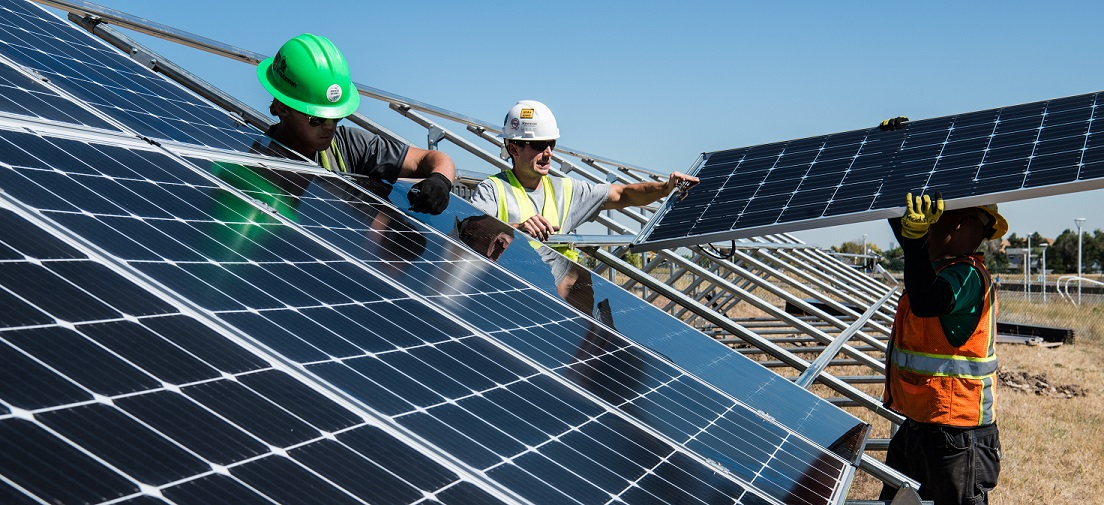
Photo by <a href="https://unsplash.com/@scienceinhd?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Science in HD</a> on <a href="https://unsplash.com/s/photos/solar-energy?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Unsplash</a>

# 1. Introduction


With increasing instances of wildfire, flooding, global warming, and other natural disasters, the thrust on transition to renewable sources of energy is getting stronger. Many countries have committed to reduce fossil fuel consumption and shift to alternative sources of energy like solar, wind and hydro power which cause zero damage to the climate in terms of green house gas emissions. Unlike fossil fuels, they are also available in plenty and are inexhaustible.

In order to assist countries in achieving their goals of sustainable development, the World Bank Group partnered with Solargis to release Global Solar Atlas (GSA) [https://globalsolaratlas.info/]. It provides quick and easy access to solar energy potential for any site or region in the world. The photovoltaic (PV) yield estimates are generated by simulation models using solar radiation and meterological data. Readers are encouraged to refer to the technical document to know more about how the estimates are calculated (https://documents1.worldbank.org/curated/en/529431592893043403/pdf/Global-Solar-Atlas-2-0-Technical-Report.pdf). These preliminary estimates can help policymakers, researchers, and commercial solar companies take better decisions. In this blog post, I will demonstrate how to use the GIS data layers provided by GSA to extract PV potential data for any region. A caveat of using these estimates is that they do not account for many factors which may impact PV potential of a region and therefore, more detailed estimation tools should be used to obtain a precise estimate of energy yield.

# 2. Workflow

The granularity of the GIS data allows us to estimate PV potential for any region - big or small - like districts, states, countries etc. The pixel level information captured in these raster files can be easily aggregated in Google Earth Engine (GEE) to derive the estimates in a fraction of seconds. The raster images can also be analysed using free and open source GUI softwares like QGIS but nothing can beat the level of integration that can be achieved in Jupyter Notebook using Python.

There are four broad steps:

* Download the GIS data. The PVOUT GeoTiff file is what we are looking for.
* Upload the GIS data to assets in GEE. Essentially, we are loading the data to GEE to leverage the power of Google's cloud computing architecture to speed up our analysis.
* Overlay the raster image with vector shapes. Use GEE functions to group the pixel level info as per vector boundaries and reduce them to a single statistic of PV potential for each polygon boundary by summing them up.
* Convert the GEE `FeatureCollection` into a pandas dataframe and calculate PV potential per unit area

# 3. Coding in GEE and exporting results

We will begin by importing the earth engine and geemap libraries. Next, we initialize and aythenticate the connection to GEE. We import the FAO-GAUL vector layer for India at the state/UT level and calculate the area of each polygon. We also import the raster for solar potential and aggregate the pixel level information to the state/UT level by summing them. Pixel values in the raster represent long term yearly average of daily total power production potential for a PV power plant with free-standing fixed-mounted crystalline silicon (c-Si) modules mounted at optimum tilt to maximize yearly PV production. 

In [1]:
# Import the relevant libraries
import ee
import geemap
import pandas as pd

In [2]:
# Initalize Earth Engine
try:
    ee.Initialize()
except:
    ee.Authenticate()
    ee.Initialize()

In [3]:
# Accessing state level polygon boundaries of India using FAO dataset
india = ee.FeatureCollection("FAO/GAUL/2015/level1") \
            .filter(ee.Filter.eq('ADM0_NAME', 'India'))

In [4]:
# Access the solar potential raster image saved as GEE asset
solarpot = ee.Image("users/skantbksc/pvpot")

In [5]:
# Add reducer output to the Features in the collection.
solarPotFC = solarpot.reduceRegions(
  collection =  india,
  reducer = ee.Reducer.mean(),
);

In [6]:
# Convert the GEE Feature Collection into a pandas dataframe
solarPotdf = geemap.ee_to_pandas(solarPotFC)

In [7]:
# Sort the dataframe by PV potential per unit area
solarPotdf[['ADM1_NAME','mean']].sort_values(by='mean', ascending = False)

,ADM1_NAME,mean
32,Daman and Diu,4.669878
11,Gujarat,4.649167
24,Rajasthan,4.618611
3,Madhya Pradesh,4.425964
16,Lakshadweep,4.385611
17,Maharashtra,4.381885
14,Karnataka,4.370794
1,Chhattisgarh,4.365614
31,Dadra and Nagar Haveli,4.360056
33,Puducherry,4.310189


In [12]:
# Exporting the dataframe to local machine
geemap.ee_export_vector(solarPotFC, 'solarPotFC.csv',selectors = ['ADM1_NAME','mean'])

Generating URL ...
Please wait ...
Data downloaded to C:\Users\ADMIN\Desktop\satellite\geemap\solarPotFC.csv


For users who love to work with GEE code editor, java script is as follows:

In [ ]:
'''
// Accessing state level polygon boundaries of India using FAO dataset
var india = ee.FeatureCollection("FAO/GAUL/2015/level1")
            .filter(ee.Filter.eq('ADM0_NAME', 'India'));
            
// Access the solar potential raster image saved as GEE asset
var solarpot = ee.Image("users/skantbksc/pvpot");

// Add reducer output to the Features in the collection.
var solarPotFC = solarpot.reduceRegions({
  collection :  india,
  reducer : ee.Reducer.mean()
  });
  
Export.table.toDrive({
  collection: solarPotFC,
  description: 'solar_potential',
  folder:'satellite',
  fileFormat: 'CSV',
  selectors: ['ADM1_NAME','mean']
});

'''

# 4. Conclusion


PV output depends on several factors such as amount of solar radiation falling on the PV module, inclination angle, air temperature, amount of dust/aerosols in the sky, clouds, cleaning of the PV modules surface, shadows due to external obstacles situated close to PV system and so on. While incorporating all the variables accurately into the simulation may not be possible, GSA lays down results from simulation exercises which use historical solar radiation, temperature and meteorological data. The GSA provides these results in the form of GIS data layers which can be analysed readily with GEE. In an illustration using vector data for India from FAO-GAUL dataset, we saw that the western states of India are relatively richer in solar power potential than the eastern and north-eastern states.


# References

* [Data/information/map] obtained from the “Global Solar Atlas 2.0, a free, web-based application is developed and operated by the company Solargis s.r.o. on behalf of the World Bank Group, utilizing Solargis data, with funding provided by the Energy Sector Management Assistance Program (ESMAP). For additional information: https://globalsolaratlas.info

* Wu, Q., (2020). geemap: A Python package for interactive mapping with Google Earth Engine. The Journal of Open Source Software, 5(51), 2305. https://doi.org/10.21105/joss.02305

* Gorelick, N., Hancher, M., Dixon, M., Ilyushchenko, S., Thau, D., & Moore, R. (2017). Google Earth Engine: Planetary-scale geospatial analysis for everyone. Remote Sensing of Environment.